In [5]:
# --- Car Price Prediction using your columns ---
# Text: Company Names, Cars Names, Fuel Types
# Numeric: HorsePower, Total Speed
# Target: Cars Prices

import re
import numpy as np
import pandas as pd
import unicodedata as ud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ========= 1) LOAD =========
file_path = "/Users/atheequehasan/Downloads/CSV/NewCopy15cleanCarsCopy1df_filtered.csv"
df = pd.read_csv(file_path, encoding="utf-8-sig")  # BOM-safe

# (Optional) normalize weird whitespace in column names
def _clean_col(s: str) -> str:
    s = ud.normalize("NFKC", str(s))
    s = s.replace("\ufeff", "").replace("\u200b", "").replace("\u200c", "").replace("\u200d", "")
    return " ".join(s.strip().split())
df.columns = [_clean_col(c) for c in df.columns]

print("Columns found:", list(df.columns))

# ========= 2) LOAD & NUMERIC TYPE PARSING =========
# Re-load with thousands handling
df = pd.read_csv(file_path, encoding="utf-8-sig", thousands=",")

# helper to coerce strings like "150 hp" → 150, "220 km/h" → 220
def to_number(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.replace(r"[^\d.]+", "", regex=True), errors="coerce")

# enforce numeric
df["Cars Prices"] = to_number(df["Cars Prices"])
df["HorsePower"]  = to_number(df.get("HorsePower"))
df["Total Speed"] = to_number(df.get("Total Speed"))
df["Seats"]       = pd.to_numeric(df["Seats"], errors="raise")

# Drop rows with missing target
df = df.dropna(subset=["Cars Prices"]).reset_index(drop=True)

# ========= 3) FEATURES =========
text_cols = ["Company Names", "Cars Names", "Fuel Types"]
num_cols  = ["HorsePower", "Total Speed","Seats"]   
target    = "Cars Prices"

# Sanity check
missing = set(text_cols + num_cols + [target]) - set(df.columns)
if missing:
    raise KeyError(f"Missing columns: {missing}")

# ========= 4) PIPELINE: TF-IDF (text) + NUMERIC =========
def combine_text(X):
    """Combine the selected text columns into a single string per row."""
    if isinstance(X, pd.DataFrame):
        return (X.astype(str).agg(" ".join, axis=1)).to_numpy()
    return (pd.DataFrame(X).astype(str).agg(" ".join, axis=1)).to_numpy()

text_pipe = Pipeline(steps=[
    ("combine", FunctionTransformer(combine_text, validate=False)),
    # Keep tokens like '1.5T', 'i-VTEC', 'G-Limited'
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),
        min_df=3,
        max_features=30000,
        token_pattern=r"(?u)\b[\w\.-]+\b"
    ))
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # plays nicely with sparse TF-IDF
])

pre = ColumnTransformer([
    ("text", text_pipe, text_cols),
    ("num",  num_pipe,  num_cols),
])

# Regularized linear model on log(price)
reg = RidgeCV(alphas=np.logspace(-3, 3, 25))

model = Pipeline([
    ("pre", pre),
    ("reg", reg)
])

# ========= 5) TRAIN/TEST & FIT =========
X = df[text_cols + num_cols]
y = np.log1p(df[target])  # log target for stability

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

model.fit(X_train, y_train)

# ========= 6) EVALUATION (back on original price scale) =========
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

r2   = r2_score(np.expm1(y_test), y_pred)
mae  = mean_absolute_error(np.expm1(y_test), y_pred)
rmse = mean_squared_error(np.expm1(y_test), y_pred, squared=False)

print("\n=== Test Performance ===")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")

# ========= 7) FEATURE INSPECTION =========
ct = model.named_steps["pre"]
reg = model.named_steps["reg"]

text_vect = ct.named_transformers_["text"].named_steps["tfidf"]
text_features = text_vect.get_feature_names_out()
num_features = np.array(num_cols, dtype=object)

feature_names = np.concatenate([text_features, num_features], axis=0)
coefs = reg.coef_
assert len(coefs) == len(feature_names), (
    f"Length mismatch: {len(coefs)} coefs vs {len(feature_names)} features"
)

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
)

print("\nTop +/− features (log-price coefficients):")
print(coef_df.head(20)[["feature", "coef"]].to_string(index=False))

base_price = float(np.exp(reg.intercept_))
print(f"\nBaseline price (exp(intercept)): ~{base_price:,.0f}")


Columns found: ['Company Names', 'Cars Names', 'Engines', 'Capacity', 'HorsePower', 'Total Speed', 'Performance', 'Cars Prices', 'Fuel Types', 'Seats', 'Torque']

=== Test Performance ===
R²:   0.8826
MAE:  38,391
RMSE: 242,805

Top +/− features (log-price coefficients):
         feature      coef
     lamborghini  1.704448
      car petrol  1.041750
             car  1.041750
      HorsePower  0.780687
    nismo petrol -0.730783
     rolls royce  0.691291
           royce  0.691291
           rolls  0.691291
    ford mustang -0.666427
         mustang -0.666427
          chiron -0.609434
  bugatti chiron -0.609434
           nismo  0.580210
         bugatti -0.564025
            urus -0.560781
lamborghini urus -0.560781
       chevrolet -0.556493
           super -0.524701
          f-type -0.493768
   jaguar f-type -0.493768

Baseline price (exp(intercept)): ~8,956


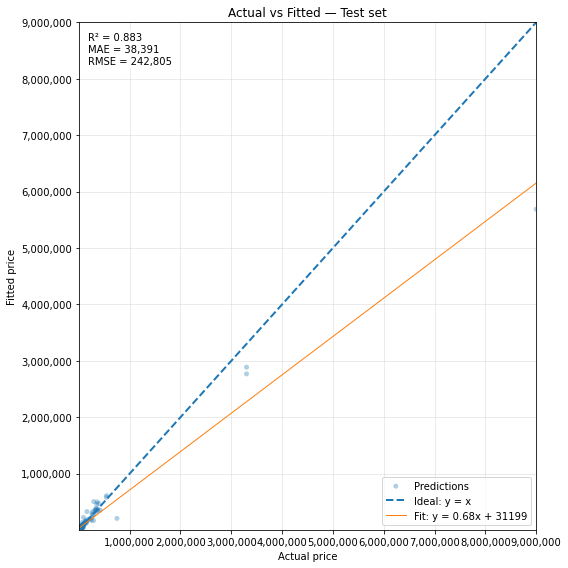

In [6]:
# ========= 8) PLOT: Actual vs Fitted (Test set) =========
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on test in original price scale
y_true = np.expm1(y_test)
y_fit  = np.expm1(model.predict(X_test))

# Metrics
r2   = r2_score(y_true, y_fit)
mae  = mean_absolute_error(y_true, y_fit)
rmse = mean_squared_error(y_true, y_fit, squared=False)

# Plot limits
mn = float(np.nanmin([y_true.min(), y_fit.min()]))
mx = float(np.nanmax([y_true.max(), y_fit.max()]))

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_true, y_fit, alpha=0.35, s=25, edgecolor="none", label="Predictions")
ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=2, label="Ideal: y = x")

# Optional: simple linear fit to highlight bias
m, b = np.polyfit(y_true, y_fit, 1)
ax.plot([mn, mx], [m*mn + b, m*mx + b], linewidth=1, label=f"Fit: y = {m:.2f}x + {b:.0f}")

ax.set_xlim(mn, mx); ax.set_ylim(mn, mx)
ax.set_xlabel("Actual price"); ax.set_ylabel("Fitted price")
ax.set_title("Actual vs Fitted — Test set")

# Pretty ticks
fmt = FuncFormatter(lambda x, _ : f"{x:,.0f}")
ax.xaxis.set_major_formatter(fmt); ax.yaxis.set_major_formatter(fmt)

ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")  # bottom-right legend

# Metrics box
ax.text(
    0.02, 0.98,
    f"R² = {r2:.3f}\nMAE = {mae:,.0f}\nRMSE = {rmse:,.0f}",
    transform=ax.transAxes, va="top", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="none")
)

plt.tight_layout()
# plt.savefig("actual_vs_fitted_test.png", dpi=200)
plt.show()
